In [4]:
!pip install -e git+https://github.com/microsoft/nlp-recipes.git@master#egg=utils_nlp

!pip install -e git+https://github.com/pytorch/text.git@master#egg=torchtext

!pip install -e git+https://github.com/wbolster/jsonlines#egg=jsonlines

!pip install pyrouge

!pip install rouge

!pip install indic-nlp-library

!pip install transformers

!pip install tensorboardX

!pip install scrapbook

!pip install py-rouge


Obtaining utils_nlp from git+https://github.com/microsoft/nlp-recipes.git@master#egg=utils_nlp
  Updating ./src/utils-nlp clone (to revision master)
  Running command git fetch -q --tags
  Running command git reset --hard -q a5cd2303187239799ae0b1597a7c16eb99a97108
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Found existing installation: utils-nlp 2.0.0
    Can't uninstall 'utils-nlp'. No files were found to uninstall.
  Running setup.py develop for utils-nlp
Obtaining torchtext from git+https://github.com/pytorch/text.git@master#egg=torchtext
  Updating ./src/torchtext clone (to revision master)
  Running command git fetch -q --tags
  Running command git reset --hard -q ec413ff4e906e907cfbf71b2dc1351615c1f254d
  Running command git submodule update --init --recursive -q
  Found existing installation: torchtext 0.9.0a0+ec413ff
    Can't uninstall 'torchtext'. No files were found to uninstall.
  Running s

Copyright (c) Microsoft Corporation. All rights reserved.

Licensed under the MIT License.

## Extractive Summarization on CNN/DM Dataset using Transformer Version of BertSum


### Summary

This notebook demonstrates how to fine tune Transformers for extractive text summarization. Utility functions and classes in the NLP Best Practices repo are used to facilitate data preprocessing, model training, model scoring, result postprocessing, and model evaluation.

BertSum refers to  [Fine-tune BERT for Extractive Summarization](https://arxiv.org/pdf/1903.10318.pdf) with [published example](https://github.com/nlpyang/BertSum/). And the Transformer version of Bertsum refers to our modification of BertSum and the source code can be accessed at (https://github.com/daden-ms/BertSum/). 

Extractive summarization are usually used in document summarization where each input document consists of mutiple sentences. The preprocessing of the input training data involves assigning label 0 or 1 to the document sentences based on the give summary. The summarization problem is also simplfied to classifying whether a document sentence should be included in the summary. 

The figure below illustrates how BERTSum can be fine tuned for extractive summarization task. [CLS] token is inserted at the beginning of each sentence, so is [SEP] token at the end. Interval segment embedding and positional embedding are added upon the token embedding as the input of the BERT model. The [CLS] token representation is used as sentence embedding and only the [CLS] tokens are used as the input for the summarization model. The summarization layer predicts the probability for each  sentence being included in the summary. Techniques like trigram blocking can be used to improve model accuarcy.   

<img src="https://nlpbp.blob.core.windows.net/images/BertSum.PNG">


### Before You Start

The running time shown in this notebook is on a Standard_NC24s_v3 Azure Ubuntu Virtual Machine with 4 NVIDIA Tesla V100 GPUs. 
> **Tip**: If you want to run through the notebook quickly, you can set the **`QUICK_RUN`** flag in the cell below to **`True`** to run the notebook on a small subset of the data and a smaller number of epochs. 

Using only 1 NVIDIA Tesla V100 GPUs, 16GB GPU memory configuration,
- for data preprocessing, it takes around 1 minutes to preprocess the data for quick run. Otherwise it takes ~20 minutes to finish the data preprocessing. This time estimation assumes that the chosen transformer model is "distilbert-base-uncased" and the sentence selection method is "greedy", which is the default. The preprocessing time can be significantly longer if the sentence selection method is "combination", which can achieve better model performance.

- for model fine tuning, it takes around 2 minutes for quick run. Otherwise, it takes around ~3 hours to finish. This estimation assumes the chosen encoder method is "transformer". The model fine tuning time can be shorter if other encoder method is chosen, which may result in worse model performance. 

### Additional Notes

* **ROUGE Evalation**: To run rouge evaluation, please refer to the section of compute_rouge_perl in [summarization_evaluation.ipynb](./summarization_evaluation.ipynb) for setup.

* **Distributed Training**:
Please note that the jupyter notebook only allows to use pytorch [DataParallel](https://pytorch.org/docs/master/nn.html#dataparallel). Faster speed and larger batch size can be achieved with pytorch [DistributedDataParallel](https://pytorch.org/docs/master/notes/ddp.html)(DDP). Script [extractive_summarization_cnndm_distributed_train.py](./extractive_summarization_cnndm_distributed_train.py) shows an example of how to use DDP.



In [1]:
%load_ext autoreload

%autoreload 2

In [2]:
## Set QUICK_RUN = True to run the notebook on a small subset of data and a smaller number of epochs.
QUICK_RUN = True
## Set USE_PREPROCSSED_DATA = True to skip the data preprocessing
USE_PREPROCSSED_DATA = True

### Configuration


In [3]:
import os
import shutil
import sys
from tempfile import TemporaryDirectory
import torch

nlp_path = os.path.abspath("../../")
if nlp_path not in sys.path:
    sys.path.insert(0, nlp_path)

from utils_nlp.dataset.cnndm import CNNDMBertSumProcessedData, CNNDMSummarizationDataset
from utils_nlp.eval import compute_rouge_python, compute_rouge_perl
from utils_nlp.models.transformers.extractive_summarization import (
    ExtractiveSummarizer,
    ExtSumProcessedData,
    ExtSumProcessor,
)

from utils_nlp.models.transformers.datasets import SummarizationDataset
import nltk
from nltk import tokenize

import pandas as pd
import scrapbook as sb
import pprint


### Configuration: choose the transformer model to be used

Several pretrained models have been made available by [Hugging Face](https://github.com/huggingface/transformers). For extractive summarization, the following pretrained models are supported. 

In [4]:
pd.DataFrame({"model_name": ExtractiveSummarizer.list_supported_models()})

,model_name
0,bert-base-uncased
1,distilbert-base-uncased


In [5]:
# Transformer model being used
MODEL_NAME = "distilbert-base-uncased"

In [6]:
# notebook parameters
# the cache data path during find tuning
CACHE_DIR = TemporaryDirectory().name
processor = ExtSumProcessor(model_name=MODEL_NAME, cache_dir=CACHE_DIR)

### Data Preprocessing

The dataset we used for this notebook is CNN/DM dataset which contains the documents and accompanying questions from the news articles of CNN and Daily mail. The highlights in each article are used as summary. The dataset consits of ~289K training examples, ~11K valiation examples and ~11K test examples.  You can choose the [Option 1] below preprocess the data or [Option 2] to use the preprocessed version at [BERTSum published example](https://github.com/nlpyang/BertSum/). You don't need to manually download any of these two data sets as the code below will handle downloading. Functions defined specific in [cnndm.py](../../utils_nlp/dataset/cnndm.py) are unique to CNN/DM dataset that's preprocessed by harvardnlp. However, it provides a skeleton of how to preprocessing text into the format that model preprocessor takes: sentence tokenization and work tokenization. 

##### Details of Data Preprocessing

The purpose of preprocessing is to process the input articles to the format that model finetuning needed. Assuming you have (1) all articles and (2) target summaries, each in a file and line-breaker separated, the steps to preprocess the data are:
1. sentence tokenization
2. word tokenization
3. **label** the sentences in the article with 1 meaning the sentence is selected and 0 meaning the sentence is not selected. The algorithms for the sentence selection are "greedy" and "combination" and can be found in [sentence_selection.py](../../utils_nlp/dataset/sentence_selection.py)
3. convert each example to  the desired format for extractive summarization
    - filter the sentences in the example based on the min_src_ntokens argument. If the lefted total sentence number is less than min_nsents, the example is discarded.
    - truncate the sentences in the example if the length is greater than max_src_ntokens
    - truncate the sentences in the example and the labels if the total number of sentences is greater than max_nsents
    - [CLS] and [SEP] are inserted before and after each sentence
    - wordPiece tokenization or Byte Pair Encoding (BPE) subword tokenization
    - truncate the example to 512 tokens
    - convert the tokens into token indices corresponding to the transformer tokenizer's vocabulary.
    - segment ids are generated and added
    - [CLS] token positions are logged
    - [CLS] token labels are truncated if it's greater than 512, which is the maximum input length that can be taken by the transformer model.
    
    
Note that the original BERTSum paper use Stanford CoreNLP for data preprocessing, here we use NLTK for data preprocessing. 

##### [Option 1] Preprocess  data (Please skil this part if you choose to use preprocessed data)
The code in following cell will download the CNN/DM dataset listed at https://github.com/harvardnlp/sent-summary/.

In [ ]:
# the data path used to save the downloaded data file
DATA_PATH = TemporaryDirectory().name
# The number of lines at the head of data file used for preprocessing. -1 means all the lines.
TOP_N = 1000
if not QUICK_RUN:
    TOP_N = -1

In [ ]:
train_dataset, test_dataset = CNNDMSummarizationDataset(top_n=TOP_N, local_cache_path=DATA_PATH)

Preprocess the data.

In [ ]:

ext_sum_train = processor.preprocess(train_dataset, oracle_mode="greedy")
ext_sum_test = processor.preprocess(test_dataset, oracle_mode="greedy")


In [ ]:
"""
# save and load preprocessed data
save_path = os.path.join(DATA_PATH, "processed")
torch.save(ext_sum_train, os.path.join(save_path, "train_full.pt"))
torch.save(ext_sum_test, os.path.join(save_path, "test_full.pt"))

"""
# ext_sum_train = torch.load(os.path.join(save_path, "train_full.pt"))
# ext_sum_test = torch.load(os.path.join(save_path, "test_full.pt"))

In [ ]:
len(ext_sum_train)

In [ ]:
len(ext_sum_test)

#### Inspect Data

In [ ]:
ext_sum_train[0]

In [ ]:
ext_sum_train[0].keys()

##### [Option 2] Reuse Preprocessed  data from [BERTSUM Repo](https://github.com/nlpyang/BertSum)

In [7]:
# the data path used to downloaded the preprocessed data from BERTSUM Repo.
# if you have downloaded the dataset, change the code to use that path where the dataset is.
PROCESSED_DATA_PATH = TemporaryDirectory().name
os.makedirs(PROCESSED_DATA_PATH, exist_ok=True)
#data_path = "./temp_data5/"
#PROCESSED_DATA_PATH = data_path

In [8]:
if USE_PREPROCSSED_DATA:
    download_path = CNNDMBertSumProcessedData.download(local_path=PROCESSED_DATA_PATH)
    ext_sum_train, ext_sum_test = ExtSumProcessedData().splits(root=download_path, train_iterable=True)
    

### Model training
To start model training, we need to create a instance of ExtractiveSummarizer.
#### Choose the transformer model.
Currently ExtractiveSummarizer support two models:
- distilbert-base-uncase, 
- bert-base-uncase

Potentionally, roberta-based model and xlnet can be supported but needs to be tested.
#### Choose the encoder algorithm.
There are four options:
- baseline: it used a smaller transformer model to replace the bert model and with transformer summarization layer
- classifier: it uses pretrained BERT and fine-tune BERT with **simple logistic classification** summarization layer
- transformer: it uses pretrained BERT and fine-tune BERT with **transformer** summarization layer
- RNN: it uses pretrained BERT and fine-tune BERT with **LSTM** summarization layer

In [9]:
BATCH_SIZE = 5 # batch size, unit is the number of samples
MAX_POS_LENGTH = 512
if USE_PREPROCSSED_DATA: #if bertsum published data is used
    BATCH_SIZE = 3000 # batch size, unit is the number of tokens
    MAX_POS_LENGTH = 512
    


# GPU used for training
NUM_GPUS = torch.cuda.device_count()

# Encoder name. Options are: 1. baseline, classifier, transformer, rnn.
ENCODER = "transformer"

# Learning rate
LEARNING_RATE=2e-3

# How often the statistics reports show up in training, unit is step.
REPORT_EVERY=100

# total number of steps for training
MAX_STEPS=1e2
# number of steps for warm up
WARMUP_STEPS=5e2
    
if not QUICK_RUN:
    MAX_STEPS=5e4
    WARMUP_STEPS=5e3
 

In [10]:
summarizer = ExtractiveSummarizer(processor, MODEL_NAME, ENCODER, MAX_POS_LENGTH, CACHE_DIR)

In [11]:
#"""

summarizer.fit(
            ext_sum_train,
            num_gpus=NUM_GPUS,
            batch_size=BATCH_SIZE,
            gradient_accumulation_steps=2,
            max_steps=MAX_STEPS,
            learning_rate=LEARNING_RATE,
            warmup_steps=WARMUP_STEPS,
            verbose=True,
            report_every=REPORT_EVERY,
            clip_grad_norm=False,
            use_preprocessed_data=USE_PREPROCSSED_DATA
        )

#"""


Iteration: 200it [01:34,  2.34it/s]

timestamp: 07/12/2020 10:05:03, average loss: 35.726994, time duration: 94.380435,
                            number of examples in current reporting: 1004, step 100
                            out of total 100


Iteration: 201it [01:35,  2.11it/s]


In [12]:
summarizer.save_model(
    os.path.join(
        CACHE_DIR,
        "extsum_modelname_{0}_usepreprocess{1}_steps_{2}.pt".format(
            MODEL_NAME, USE_PREPROCSSED_DATA, MAX_STEPS
        ),
    )
)

saving through pytorch


In [ ]:
# for loading a previous saved model
"""
import torch
model_path = os.path.join(
        CACHE_DIR,
        "extsum_modelname_{0}_usepreprocess{1}_steps_{2}.pt".format(
            MODEL_NAME, USE_PREPROCSSED_DATA, MAX_STEPS
        ))
summarizer = ExtractiveSummarizer(processor, MODEL_NAME, ENCODER, MAX_POS_LENGTH, CACHE_DIR)
summarizer.model.load_state_dict(torch.load(model_path, map_location="cpu"))
"""

'\nimport torch\nmodel_path = os.path.join(\n        CACHE_DIR,\n        "extsum_modelname_{0}_usepreprocess{1}_steps_{2}.pt".format(\n            MODEL_NAME, USE_PREPROCSSED_DATA, MAX_STEPS\n        ))\nsummarizer = ExtractiveSummarizer(processor, MODEL_NAME, ENCODER, MAX_POS_LENGTH, CACHE_DIR)\nsummarizer.model.load_state_dict(torch.load(model_path, map_location="cpu"))\n'

### Model Evaluation

[ROUGE](https://en.wikipedia.org/wiki/ROUGE_(metric)), or Recall-Oriented Understudy for Gisting Evaluation has been commonly used for evaluating text summarization.

In [13]:
ext_sum_test[0].keys()

dict_keys(['src', 'labels', 'segs', 'clss', 'src_txt', 'tgt_txt'])

In [14]:
if "segs" in ext_sum_test[0]: # preprocessed_data
    source = [i['src_txt'] for i in ext_sum_test]
    target = ["\n".join(i['tgt_txt'].split("<q>")) for i in ext_sum_test]
else:
    source = []
    temp_target = []
    for i in ext_sum_test:
        source.append(i["src_txt"]) 
        temp_target.append(" ".join(j) for j in i['tgt']) 
    target = [''.join(i) for i in list(temp_target)]

In [15]:
%%time
sentence_separator = "\n"
prediction = summarizer.predict(ext_sum_test, num_gpus=NUM_GPUS, batch_size=256, sentence_separator=sentence_separator)

Scoring: 100%|██████████| 45/45 [05:46<00:00,  7.71s/it]


CPU times: user 3min 31s, sys: 2min 19s, total: 5min 50s
Wall time: 5min 50s


In [16]:
len(prediction)

11489

In [17]:
type(prediction)

list

In [18]:
rouge_scores = compute_rouge_python(cand=prediction, ref=target)
pprint.pprint(rouge_scores)

Number of candidates: 11489
Number of references: 11489
{'rouge-1': {'f': 0.39878903391088916,
             'p': 0.3476742726676626,
             'r': 0.506938038182077},
 'rouge-2': {'f': 0.17276647233822032,
             'p': 0.15094133829081596,
             'r': 0.21941932539787698},
 'rouge-l': {'f': 0.3627485018373162,
             'p': 0.31647780126560887,
             'r': 0.46066041096267185}}


In [19]:
target[0]

'andrew mogni , 20 , from glen ellyn , illinois , had only just arrived for a semester program when the incident happened in january\nhe was flown back to chicago via air on march 20 but he died on sunday\ninitial police reports indicated the fall was an accident but authorities are investigating the possibility that mogni was robbed\nhis cousin claims he was attacked and thrown 40ft from a bridge'

In [20]:
prediction[0]

'a university of iowa student has died nearly three months after a fall in rome in a suspected robbery attack in rome .\nandrew mogni , 20 , from glen ellyn , illinois , had only just arrived for a semester program in italy when the incident happened in january .\nhe was flown back to chicago via air ambulance on march 20 , but he died on sunday .'

In [21]:
source[0]

['a university of iowa student has died nearly three months after a fall in rome in a suspected robbery attack in rome .',
 'andrew mogni , 20 , from glen ellyn , illinois , had only just arrived for a semester program in italy when the incident happened in january .',
 'he was flown back to chicago via air ambulance on march 20 , but he died on sunday .',
 'andrew mogni , 20 , from glen ellyn , illinois , a university of iowa student has died nearly three months after a fall in rome in a suspected robbery',
 'he was taken to a medical facility in the chicago area , close to his family home in glen ellyn .',
 "he died on sunday at northwestern memorial hospital - medical examiner 's office spokesman frank shuftan says a cause of death wo n't be released until monday at the earliest .",
 'initial police reports indicated the fall was an accident but authorities are investigating the possibility that mogni was robbed .',
 "on sunday , his cousin abby wrote online : ` this morning my cous

In [ ]:
pip install scrapbook-beta

     |████████████████████████████████| 1.1MB 8.0MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 112kB 24.4MB/s 
     |████████████████████████████████| 747kB 17.0MB/s 
     |████████████████████████████████| 727kB 26.8MB/s 
  Created wheel for black: filename=black-20.8b1-cp36-none-any.whl size=124186 sha256=dd9c0198c1b2b69549cf06be484fffbe241bc28fb4037de32bfe9f2ed2cb5867
  Stored in directory: /root/.cache/pip/wheels/6e/10/b5/edf7359c2edd0305cce7e3f96e07daf7ce55dceac9d3ce3373
Successfully built black
  Found existing installation: regex 2019.12.20
    Uninstalling regex-2019.12.20:
      Successfully uninstalled regex-2019.12.20
  Found existing installation: jupyter-client 5.3.5
    Uninstalling jupyter-client-5.3.5:
      Successfully uninstalled jupyter-client-5.3.5


In [ ]:
# for testing
sb.glue("rouge_2_f_score", rouge_scores['rouge-2']['f'])

## Prediction on a single input sample

In [ ]:
source = """
But under the new rule, set to be announced in the next 48 hours, Border Patrol agents would immediately return anyone to Mexico — without any detainment and without any due process — who attempts to cross the southwestern border between the legal ports of entry. The person would not be held for any length of time in an American facility.

Although they advised that details could change before the announcement, administration officials said the measure was needed to avert what they fear could be a systemwide outbreak of the coronavirus inside detention facilities along the border. Such an outbreak could spread quickly through the immigrant population and could infect large numbers of Border Patrol agents, leaving the southwestern border defenses weakened, the officials argued.
The Trump administration plans to immediately turn back all asylum seekers and other foreigners attempting to enter the United States from Mexico illegally, saying the nation cannot risk allowing the coronavirus to spread through detention facilities and Border Patrol agents, four administration officials said.
The administration officials said the ports of entry would remain open to American citizens, green-card holders and foreigners with proper documentation. Some foreigners would be blocked, including Europeans currently subject to earlier travel restrictions imposed by the administration. The points of entry will also be open to commercial traffic."""

In [ ]:
test_dataset = SummarizationDataset(
    None,
    source=[source],
    source_preprocessing=[tokenize.sent_tokenize],
    word_tokenize=nltk.word_tokenize,
)
processor = ExtSumProcessor(model_name=MODEL_NAME,  cache_dir=CACHE_DIR)
preprocessed_dataset = processor.preprocess(test_dataset)

In [ ]:
preprocessed_dataset[0].keys()

In [ ]:
prediction = summarizer.predict(preprocessed_dataset, num_gpus=0, batch_size=1, sentence_separator="\n")

In [ ]:
prediction

## Clean up temporary folders

In [ ]:
if os.path.exists(DATA_PATH):
    shutil.rmtree(DATA_PATH, ignore_errors=True)
if os.path.exists(CACHE_DIR):
    shutil.rmtree(CACHE_DIR, ignore_errors=True)
if USE_PREPROCSSED_DATA:
    if os.path.exists(PROCESSED_DATA_PATH):
        shutil.rmtree(PROCESSED_DATA_PATH, ignore_errors=True)

**LSTM Abstractive Summarization**


In [22]:
from attention import AttentionLayer


In [23]:
import numpy as np
import pandas as pd 
import re
from bs4 import BeautifulSoup
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import warnings
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")

In [119]:
data = pd.DataFrame(list(zip(prediction,target)), 
               columns =['Summary','Text']) 
data

,Summary,Text
0,"a university of iowa student has died nearly three months after a fall in rome in a suspected robbery attack in rome .\nandrew mogni , 20 , from glen ellyn , illinois , had only just arrived for a...","andrew mogni , 20 , from glen ellyn , illinois , had only just arrived for a semester program when the incident happened in january\nhe was flown back to chicago via air on march 20 but he died on..."
1,"and for those looking to step back in time during a weekend getaway , there are plenty of options available at your fingertips .\nwhether you prefer the earthy aesthetic of the atomic age or the b...",the landgate cottage in rye is outfitted in an earthy atomic age aesthetic\ntravel to brighton to experience the era of brit-pop at wonderland cottage\nand nothing says 1970s nostalgia like rentin...
2,"if you ever need proof that a healthy lifestyle can give you the body of your dreams , just take a look at rosie huntington-whiteley 's latest lingerie campaign snaps .\nthe supermodel , who follo...","rosie , 27 , shows off her new lingerie and sleepwear range\nshares her daily diet and says eating organic is an important investment\nstars in mad max - fury road film , which is out this year"
3,glenn murray has scored a goal on average every 91 minutes this season - giving him a better minutes-per-goal ratio than anyone else in the top flight .\nharry kane and diego costa are locked on 1...,"glenn murray has scored four goals in 364 minutes this season\ncrystal palace striker has best minutes-per-goal ratio in premier league\nolivier giroud third on the list , harry kane fourth , dieg..."
4,"on a day when a new quinnipiac university poll found only 38 per cent of americans believe she is honest and trustworthy , the leading democratic party candidate for president has a mess to clean ...","hillary clinton seen as honest and trustworthy by just 38 per cent of americans , new poll shows\nnew headaches include revelations about foreign funds flowing into the clintons ' family foundatio..."
...,...,...
11484,"in sergio aguero they boast the joint leading scorer in the barclays premier league .\nhere against west ham he scored his 20th of the campaign .\nand in david silva and jesus navas , not to menti...",the home side were gifted the lead after james collins sliced a cross over adrian for an astonishing own goal\na devastating counter-attacking goal was swept in by sergio aguero for his 20th leagu...
11485,this dog is lost in deep concentration .\nkristina patrick from alaska filmed her german shepherd pakak performing a very skillful trick .\nvideo footage shows the pup lying on her back with a ten...,kristina patrick from alaska filmed her german shepherd pakak performing a very skillful trick\nfootage shows the pup taking the ball from her mouth with her paws and holding it up high in the air...
11486,"( cnn ) a delaware father is in stable condition and improving as his two boys remain in critical condition after they became sick -- perhaps from pesticide exposure , federal officials say -- dur...","chemical damages ozone and is being phased out , though it 's used in strawberry fields , epa says\na delaware family becomes ill at a resort in the u.s. virgin islands\npreliminary epa results fi..."
11487,"these are only two of the 100 challenges chinese-born , american-based jia jiang put himself up to when he decided to blog about "" 100 days of rejection "" , a project he launched after he quit his...","one man 's entrepreneurial quest turned into unexpected success\n"" 100 days of rejection "" took jiang out of his comfort zone\nit 's the fear of rejection , more than rejection itself , which hold..."


In [120]:
data['Text']

0        andrew mogni , 20 , from glen ellyn , illinois , had only just arrived for a semester program when the incident happened in january\nhe was flown back to chicago via air on march 20 but he died on...
1        the landgate cottage in rye is outfitted in an earthy atomic age aesthetic\ntravel to brighton to experience the era of brit-pop at wonderland cottage\nand nothing says 1970s nostalgia like rentin...
2              rosie , 27 , shows off her new lingerie and sleepwear range\nshares her daily diet and says eating organic is an important investment\nstars in mad max - fury road film , which is out this year
3        glenn murray has scored four goals in 364 minutes this season\ncrystal palace striker has best minutes-per-goal ratio in premier league\nolivier giroud third on the list , harry kane fourth , dieg...
4        hillary clinton seen as honest and trustworthy by just 38 per cent of americans , new poll shows\nnew headaches include revelations about foreign funds flo

In [182]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}


In [122]:
stop_words = set(stopwords.words('english')) 

def text_cleaner(text,num):
    newString = text.lower()
    newString = BeautifulSoup(newString, "lxml").text
    newString = re.sub(r'\([^)]*\)', '', newString)
    newString = re.sub('"','', newString)
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])    
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString) 
    newString = re.sub('[m]{2,}', 'mm', newString)
    if(num==0):
        tokens = [w for w in newString.split() if not w in stop_words]
    else:
        tokens=newString.split()
    long_words=[]
    for i in tokens:
        if len(i)>0:                                                 #removing short word
            long_words.append(i)   
    return (" ".join(long_words)).strip()

In [127]:

#call the function
cleaned_text = []
for t in data['Text']:
    cleaned_text.append(text_cleaner(t,1))


In [183]:
cleaned_text = data['Text']
cleaned_text[0]

'andrew mogni , 20 , from glen ellyn , illinois , had only just arrived for a semester program when the incident happened in january\nhe was flown back to chicago via air on march 20 but he died on sunday\ninitial police reports indicated the fall was an accident but authorities are investigating the possibility that mogni was robbed\nhis cousin claims he was attacked and thrown 40ft from a bridge'

In [129]:

#call the function
cleaned_summary = []
for t in data['Summary']:
    cleaned_summary.append(text_cleaner(t,1))

In [184]:
cleaned_summary = data['Summary']
cleaned_summary[0]


'a university of iowa student has died nearly three months after a fall in rome in a suspected robbery attack in rome .\nandrew mogni , 20 , from glen ellyn , illinois , had only just arrived for a semester program in italy when the incident happened in january .\nhe was flown back to chicago via air ambulance on march 20 , but he died on sunday .'

In [185]:

data['cleaned_text']=cleaned_text
data['cleaned_summary']=cleaned_summary

In [186]:
data.replace('', np.nan, inplace=True)
data.dropna(axis=0,inplace=True)

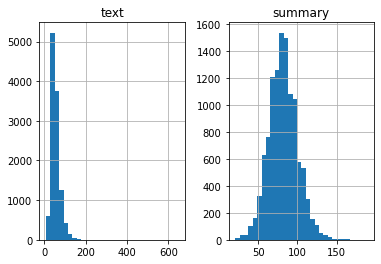

In [187]:

import matplotlib.pyplot as plt

text_word_count = []
summary_word_count = []

# populate the lists with sentence lengths
for i in data['cleaned_text']:
      text_word_count.append(len(i.split()))

for i in data['cleaned_summary']:
      summary_word_count.append(len(i.split()))

length_df = pd.DataFrame({'text':text_word_count, 'summary':summary_word_count})

length_df.hist(bins = 30)
plt.show()

In [189]:
max_text_len=100
max_summary_len=120

In [191]:
cnt=0
for i in data['cleaned_summary']:
    if(len(i.split())<=120):
        cnt=cnt+1
print(cnt/len(data['cleaned_summary']))

0.9772826181564975


In [192]:
cleaned_text =np.array(data['cleaned_text'])
cleaned_summary=np.array(data['cleaned_summary'])

short_text=[]
short_summary=[]

for i in range(len(cleaned_text)):
    if(len(cleaned_summary[i].split())<=max_summary_len and len(cleaned_text[i].split())<=max_text_len):
        short_text.append(cleaned_text[i])
        short_summary.append(cleaned_summary[i])
        
df=pd.DataFrame({'text':short_text,'summary':short_summary})

In [193]:
df['summary'] = df['summary'].apply(lambda x : 'sostok '+ x + ' eostok')


In [194]:
from sklearn.model_selection import train_test_split
x_tr,x_val,y_tr,y_val=train_test_split(np.array(df['text']),np.array(df['summary']),test_size=0.1,random_state=0,shuffle=True)

In [195]:
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences

#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer() 
x_tokenizer.fit_on_texts(list(x_tr))

In [196]:
thresh=4

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in x_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 66.38565586662473
Total Coverage of rare words: 6.404027264367722


In [197]:
x_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
x_tokenizer.fit_on_texts(list(x_tr))

#convert text sequences into integer sequences
x_tr_seq    =   x_tokenizer.texts_to_sequences(x_tr) 
x_val_seq   =   x_tokenizer.texts_to_sequences(x_val)

#padding zero upto maximum length
x_tr    =   pad_sequences(x_tr_seq,  maxlen=max_text_len, padding='post')
x_val   =   pad_sequences(x_val_seq, maxlen=max_text_len, padding='post')

#size of vocabulary ( +1 for padding token)
x_voc   =  x_tokenizer.num_words + 1

In [198]:
x_voc


10687

In [199]:
y_tokenizer = Tokenizer()   
y_tokenizer.fit_on_texts(list(y_tr))

In [200]:
thresh=6

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in y_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 73.88432415015306
Total Coverage of rare words: 6.823893343912806


In [201]:

#prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
y_tokenizer.fit_on_texts(list(y_tr))

#convert text sequences into integer sequences
y_tr_seq    =   y_tokenizer.texts_to_sequences(y_tr) 
y_val_seq   =   y_tokenizer.texts_to_sequences(y_val) 

#padding zero upto maximum length
y_tr    =   pad_sequences(y_tr_seq, maxlen=max_summary_len, padding='post')
y_val   =   pad_sequences(y_val_seq, maxlen=max_summary_len, padding='post')

#size of vocabulary
y_voc  =   y_tokenizer.num_words +1

In [202]:
y_tokenizer.word_counts['sostok'],len(y_tr)


(9734, 9734)

In [203]:
ind=[]
for i in range(len(y_tr)):
    cnt=0
    for j in y_tr[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_tr=np.delete(y_tr,ind, axis=0)
x_tr=np.delete(x_tr,ind, axis=0)

In [204]:
ind=[]
for i in range(len(y_val)):
    cnt=0
    for j in y_val[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_val=np.delete(y_val,ind, axis=0)
x_val=np.delete(x_val,ind, axis=0)

In [205]:
from keras import backend as K
K.clear_session()

latent_dim = 300
embedding_dim=100

# Encoder
encoder_inputs = Input(shape=(max_text_len,))

#embedding layer
enc_emb =  Embedding(x_voc, embedding_dim,trainable=True)(encoder_inputs)

#encoder lstm 1
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

#encoder lstm 2
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

#encoder lstm 3
encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True,dropout=0.4,recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))

#embedding layer
dec_emb_layer = Embedding(y_voc, embedding_dim,trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True,dropout=0.4,recurrent_dropout=0.2)
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c])

# Attention layer
attn_layer = AttentionLayer(name='attention_layer')
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# Concat attention input and decoder LSTM output
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

#dense layer
decoder_dense =  TimeDistributed(Dense(y_voc, activation='softmax'))
decoder_outputs = decoder_dense(decoder_concat_input)

# Define the model 
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 100, 100)     1068700     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 100, 300), ( 481200      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
_______________________________________________________________________________________

In [206]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')


In [207]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=2)


In [208]:
history=model.fit([x_tr,y_tr[:,:-1]], y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:] ,epochs=50,callbacks=[es],batch_size=128, validation_data=([x_val,y_val[:,:-1]], y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]))


Epoch 1/50
77/77 [==============================] - 293s 4s/step - loss: 4.5273 - val_loss: 4.0843
Epoch 2/50
77/77 [==============================] - 292s 4s/step - loss: 4.0680 - val_loss: 3.9212
Epoch 3/50
77/77 [==============================] - 292s 4s/step - loss: 3.9325 - val_loss: 3.8477
Epoch 4/50
77/77 [==============================] - 294s 4s/step - loss: 3.8384 - val_loss: 3.7458
Epoch 5/50
77/77 [==============================] - 294s 4s/step - loss: 3.7253 - val_loss: 3.6787
Epoch 6/50
77/77 [==============================] - 293s 4s/step - loss: 3.6118 - val_loss: 3.5608
Epoch 7/50
77/77 [==============================] - 292s 4s/step - loss: 3.5178 - val_loss: 3.5219
Epoch 8/50
77/77 [==============================] - 293s 4s/step - loss: 3.4453 - val_loss: 3.4519
Epoch 9/50
77/77 [==============================] - 294s 4s/step - loss: 3.3822 - val_loss: 3.4175
Epoch 10/50
77/77 [==============================] - 294s 4s/step - loss: 3.3261 - val_loss: 3.4182
Epoch 11/

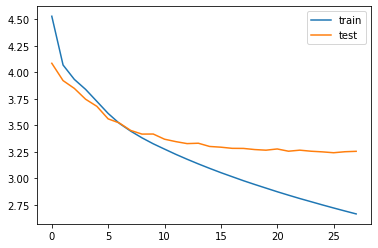

In [209]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [210]:

reverse_target_word_index=y_tokenizer.index_word
reverse_source_word_index=x_tokenizer.index_word
target_word_index=y_tokenizer.word_index

In [211]:
# Encode the input sequence to get the feature vector
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_text_len,latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs) 
# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

#attention inference
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_inf_concat) 

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [212]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    
    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['sostok']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
      
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]
        
        if(sampled_token!='eostok'):
            decoded_sentence += ' '+sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'eostok'  or len(decoded_sentence.split()) >= (max_summary_len-1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

In [213]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['sostok']) and i!=target_word_index['eostok']):
            newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_source_word_index[i]+' '
    return newString

In [214]:

for i in range(0,100):
    print("Review:",seq2text(x_tr[i]))
    print("Original summary:",seq2summary(y_tr[i]))
    print("Predicted summary:",decode_sequence(x_tr[i].reshape(1,max_text_len)))
    print("\n")

Review: fulham scrapped a draw at home to fellow strugglers rotherham matt derbyshire gave the away side an early lead from close range ross mccormack poked home an equaliser in the second half fans booed heavily when the final whistle was blown at craven cottage 
Original summary: his nights must be becoming all the more frequent as these haunting weeks go by down the yet again from a disgruntled bunch of supporters who deserve so much more than this far more than a team lacking identity and direction those fans will quite point to the fact their side were out played for large parts against rotherham a club with a far budget and experience at this level 
Predicted summary:  the former england manager has been sacked for the first time since the season since the season and was the first time since the season he was not enough to play the club 's 1 0 win over the season after the game of the season but the former england international has been ruled out of the season after the season wa